In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dlp-jan-2025-nppe-3/sample_submission.csv
/kaggle/input/dlp-jan-2025-nppe-3/submission.py
/kaggle/input/dlp-jan-2025-nppe-3/archive/val/gt/gt_00159.png
/kaggle/input/dlp-jan-2025-nppe-3/archive/val/gt/gt_00056.png
/kaggle/input/dlp-jan-2025-nppe-3/archive/val/gt/gt_00017.png
/kaggle/input/dlp-jan-2025-nppe-3/archive/val/gt/gt_00124.png
/kaggle/input/dlp-jan-2025-nppe-3/archive/val/gt/gt_00140.png
/kaggle/input/dlp-jan-2025-nppe-3/archive/val/gt/gt_00068.png
/kaggle/input/dlp-jan-2025-nppe-3/archive/val/gt/gt_00019.png
/kaggle/input/dlp-jan-2025-nppe-3/archive/val/gt/gt_00266.png
/kaggle/input/dlp-jan-2025-nppe-3/archive/val/gt/gt_00236.png
/kaggle/input/dlp-jan-2025-nppe-3/archive/val/gt/gt_00148.png
/kaggle/input/dlp-jan-2025-nppe-3/archive/val/gt/gt_00152.png
/kaggle/input/dlp-jan-2025-nppe-3/archive/val/gt/gt_00226.png
/kaggle/input/dlp-jan-2025-nppe-3/archive/val/gt/gt_00008.png
/kaggle/input/dlp-jan-2025-nppe-3/archive/val/gt/gt_00216.png
/kaggle/input/dlp-jan-2025-n

In [2]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:32'  # Reduces fragmentation

# Install required libraries

In [3]:
!pip install torch==1.12.1 torchvision==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu113
!pip install basicsr #this contains swinIR implementation from BasicSR library
!pip install opencv-python scikit-image

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 489.6 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 63.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu121
    Uninstalling torch-2.5.1+cu121:
      Successfully uninstalled torch-2.5.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.1+cu121
    Uninstalling torchvision-0.20.1+cu121:
      Successfully uninstalled torchvision-0.20.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.14.0 requires torch>=1.13.0, but you have torch 1.12.1+cu113 which is incompatible.
pytorch-lightning 2.5.0.post0 requires torch>=2.1.0, but you have torch 1.12.1+cu113 which is incompatible.
s

# Import libraries and set device

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from basicsr.archs.swinir_arch import SwinIR
import cv2
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import time

# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualizing dataset

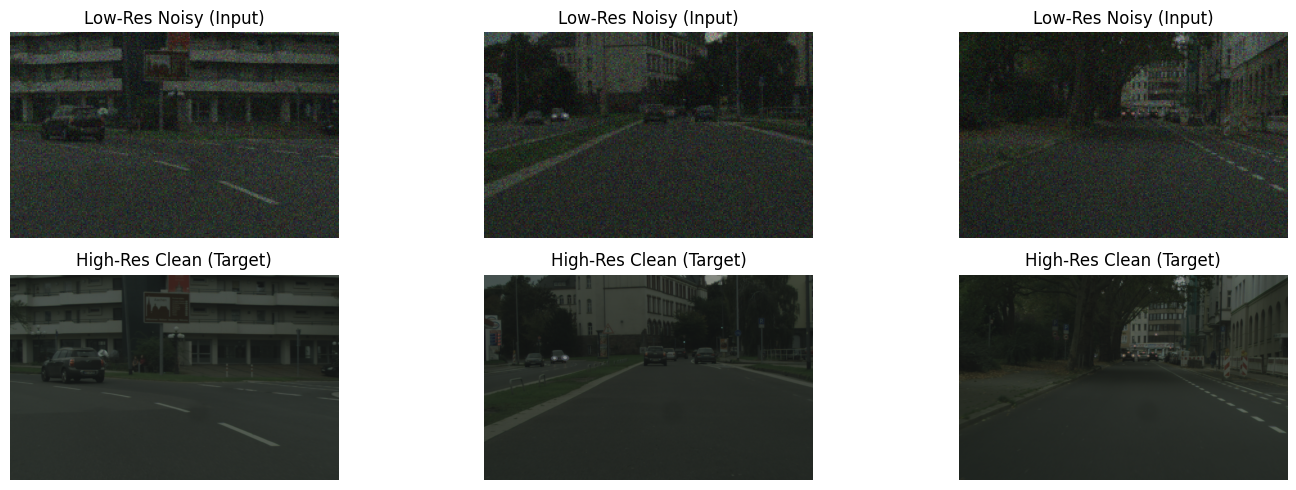

In [5]:
def plot_images(lr_img_path, hr_img_path, num_samples=3):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        lr_img = Image.open(lr_img_path[i])
        hr_img = Image.open(hr_img_path[i])
        
        plt.subplot(2, num_samples, i+1)
        plt.imshow(lr_img)
        plt.title(f"Low-Res Noisy (Input)")
        plt.axis('off')
        
        plt.subplot(2, num_samples, i+num_samples+1)
        plt.imshow(hr_img)
        plt.title(f"High-Res Clean (Target)")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

train_lr_dir = "/kaggle/input/dlp-jan-2025-nppe-3/archive/train/train"
train_hr_dir = "/kaggle/input/dlp-jan-2025-nppe-3/archive/train/gt"

lr_samples = [os.path.join(train_lr_dir, f) for f in sorted(os.listdir(train_lr_dir))[:3]]
hr_samples = [os.path.join(train_hr_dir, f) for f in sorted(os.listdir(train_hr_dir))[:3]]

plot_images(lr_samples, hr_samples)

# Dataset and Dataloader setup

* Custom Dataset class loads LR (noisy) & HR (clean) pairs.
* Normalizes images to [-1, 1].
* DataLoader batches images for training.

In [6]:
class DenoiseSRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.transform = transform
        self.lr_images = sorted(os.listdir(lr_dir))
        self.hr_images = sorted(os.listdir(hr_dir))
    
    def __len__(self):
        return len(self.lr_images)
    
    def __getitem__(self, idx):
        lr_img = Image.open(os.path.join(self.lr_dir, self.lr_images[idx])).convert('RGB')
        hr_img = Image.open(os.path.join(self.hr_dir, self.hr_images[idx])).convert('RGB')
        
        if self.transform:
            lr_img = self.transform(lr_img)
            hr_img = self.transform(hr_img)
        
        return lr_img, hr_img

transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # [-1, 1]
])

train_dataset = DenoiseSRDataset(train_lr_dir, train_hr_dir, transform)
val_dataset = DenoiseSRDataset("/kaggle/input/dlp-jan-2025-nppe-3/archive/val/val", "/kaggle/input/dlp-jan-2025-nppe-3/archive/val/gt", transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Initialize swinIR model

SwinIR (Shifted Window-based Image Restoration) is a state-of-the-art Transformer-CNN hybrid model specifically designed for:


* Super-resolution (4x upscaling)
* Low-light denoising
* Detail recovery in degraded images


In [7]:
model = SwinIR(
    upscale=4,#Sets 4× super-resolution 
    in_chans=3,#Processes 3-channel RGB images
    img_size=64,#Processes 64×64 pixel patches
    window_size=8,#Analyzes 8×8 local windows in the attention mechanism
    img_range=1.0,
    depths=[4, 4, 4, 4],
    embed_dim=48,
    num_heads=[4, 4, 4, 4],
    mlp_ratio=2,
    upsampler='pixelshuffledirect',
    resi_connection='1conv'
).to(device)

print(f"Total parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

/usr/local/lib/python3.10/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Total parameters: 0.44M


# Training loop

In [8]:
torch.cuda.empty_cache()

In [9]:
!nvidia-smi

Sun Apr  6 04:21:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P0             26W /   70W |     619MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
epochs = 30

scaler = GradScaler()
best_psnr = 0.0
history = {'train_loss' : [], 'val_psnr' : []}

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    #train_bar = tqdm(train_loader, desc="Training", leave=False)
    
    for lr_imgs, hr_imgs in train_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        
        optimizer.zero_grad()
        with autocast():
            outputs = model(lr_imgs)
            loss = criterion(outputs, hr_imgs)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
        #train_bar.set_postfix(loss=loss.item())
        
    avg_train_loss = train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    
    model.eval()
    val_psnr = 0.0
    #val_bar = tqdm(val_loader, desc="Validation", leave=False)
    
    with torch.no_grad():
        for lr_imgs, hr_imgs in val_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            outputs = model(lr_imgs)
            
            outputs_np = outputs.clamp(-1, 1).cpu().numpy() * 0.5 + 0.5
            hr_imgs_np = hr_imgs.clamp(-1, 1).cpu().numpy() * 0.5 + 0.5
            
            for out, hr in zip(outputs_np, hr_imgs_np):
                val_psnr += psnr(hr, out, data_range=1.0)
                #val_bar.set_postfix(psnr=batch_psnr)
    
    #avg_train_loss = train_loss / len(train_loader)
    avg_val_psnr = val_psnr / len(val_dataset)
    history['val_psnr'].append(avg_val_psnr)
    
    print(f"Epoch {epoch+1}/30 | Train Loss: {avg_train_loss:.4f} | Val PSNR: {avg_val_psnr:.2f} dB")
    
    if avg_val_psnr > best_psnr:
        best_psnr = avg_val_psnr
        torch.save(model.state_dict(), "best_swinir.pth")
        print(f"New best model saved! (PSNR: {best_psnr:.2f} dB)")
    
    scheduler.step(avg_train_loss)
    
print(f"\nTraining completed!")
print(f"Best Validation PSNR: {best_psnr:.2f} dB")

Epoch 1/30 | Train Loss: 0.1081 | Val PSNR: 26.71 dB
New best model saved! (PSNR: 26.71 dB)
Epoch 2/30 | Train Loss: 0.0497 | Val PSNR: 28.19 dB
New best model saved! (PSNR: 28.19 dB)
Epoch 3/30 | Train Loss: 0.0433 | Val PSNR: 29.61 dB
New best model saved! (PSNR: 29.61 dB)
Epoch 4/30 | Train Loss: 0.0390 | Val PSNR: 31.46 dB
New best model saved! (PSNR: 31.46 dB)
Epoch 5/30 | Train Loss: 0.0355 | Val PSNR: 32.93 dB
New best model saved! (PSNR: 32.93 dB)
Epoch 6/30 | Train Loss: 0.0327 | Val PSNR: 34.23 dB
New best model saved! (PSNR: 34.23 dB)
Epoch 7/30 | Train Loss: 0.0311 | Val PSNR: 34.74 dB
New best model saved! (PSNR: 34.74 dB)
Epoch 8/30 | Train Loss: 0.0299 | Val PSNR: 35.48 dB
New best model saved! (PSNR: 35.48 dB)
Epoch 9/30 | Train Loss: 0.0293 | Val PSNR: 35.70 dB
New best model saved! (PSNR: 35.70 dB)
Epoch 10/30 | Train Loss: 0.0286 | Val PSNR: 35.95 dB
New best model saved! (PSNR: 35.95 dB)
Epoch 11/30 | Train Loss: 0.0282 | Val PSNR: 36.11 dB
New best model saved! (PS

# Validation

In [11]:
model.load_state_dict(torch.load("best_swinir.pth"))
model.eval()

val_psnr = 0.0
#val_ssim = 0.0

with torch.no_grad():
    for lr_imgs, hr_imgs in val_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        outputs = model(lr_imgs)
        
        outputs_np = outputs.clamp(-1, 1).cpu().numpy() * 0.5 + 0.5
        hr_imgs_np = hr_imgs.clamp(-1, 1).cpu().numpy() * 0.5 + 0.5
        
        for out, hr in zip(outputs_np, hr_imgs_np):
            val_psnr += psnr(hr, out, data_range=1.0)
            #val_ssim += ssim(hr, out, multichannel=True, data_range=1.0)

avg_psnr = val_psnr / len(val_dataset)
#avg_ssim = val_ssim / len(val_dataset)

print(f"Validation PSNR: {avg_psnr:.2f} dB")
#print(f"Validation SSIM: {avg_ssim:.4f}")

Validation PSNR: 37.64 dB


# Test prediction and submission

In [12]:
test_lr_dir = "/kaggle/input/dlp-jan-2025-nppe-3/archive/test"
test_images = sorted(os.listdir(test_lr_dir))

os.makedirs("/kaggle/working/enhanced_test_images", exist_ok=True)

model.eval()
with torch.no_grad():
    for img_name in test_images:
        lr_img = Image.open(os.path.join(test_lr_dir, img_name)).convert('RGB')
        lr_tensor = transform(lr_img).unsqueeze(0).to(device)
        
        sr_tensor = model(lr_tensor)
        sr_img = (sr_tensor.squeeze(0).clamp(-1, 1).cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5) * 255
        sr_img = sr_img.astype(np.uint8)
        
        output_path = os.path.join("/kaggle/working/enhanced_test_images", img_name)
        cv2.imwrite(output_path, cv2.cvtColor(sr_img, cv2.COLOR_RGB2BGR))

print("Test predictions saved to /kaggle/working/enhanced_test_images")

Test predictions saved to /kaggle/working/enhanced_test_images


In [13]:
import os
import numpy as np
import pandas as pd
from PIL import Image

def images_to_csv(folder_path, output_csv):
    data_rows = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert('L') 
            image_array = np.array(image).flatten()[::8]
            # Replace 'test_' with 'gt_' in the ID
            image_id = filename.split('.')[0].replace('test_', 'gt_')
            data_rows.append([image_id, *image_array])
    column_names = ['ID'] + [f'pixel_{i}' for i in range(len(data_rows[0]) - 1)]
    df = pd.DataFrame(data_rows, columns=column_names)
    df.to_csv(output_csv, index=False)
    print(f'Successfully saved to {output_csv}')

In [14]:
folder_path="/kaggle/working/enhanced_test_images"
output_csv="submission.csv"
images_to_csv(folder_path, output_csv)

Successfully saved to submission.csv


In [ ]:
kkkkggggggbbbnnnhhhbbbmmmgggjjjkkkhhbbbiiii